# 프로젝트 : 뉴스기사 요약해보기

## <목차>
### Step 1. 데이터 수집하기   
### Step 2. 데이터 전처리하기 (추상적 요약)   
(1)중복 샘플과 NULL 값이 존재하는 샘플 제거   
(2)텍스트 정규화와 불용어 제거   
(3) 샘플의 최대 길이 정하기   
(4) 시작 토큰과 종료 토큰 추가하기   
(5) 단어 집합(vocabulary) 만들기 및 정수 인코딩   
(6) 패딩하기   
### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)   
### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)   
### Step 5. Summa을 이용해서 추출적 요약해보기
(1) 데이터 다운로드   
(2) summarize 사용하기   
### 🤔회고🤔

# Step 1. 데이터 수집하기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('패키지 준비 완료!')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


패키지 준비 완료!


In [5]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('전체 샘플수 :', (len(data)))
data.sample(10)

전체 샘플수 : 98401


,headlines,text
49952,"14-year-old Navi Mumbai boy smashes 1,045 runs...","Tanishq Gavate, a 14-year-old Navi Mumbai stud..."
73796,ISIS planned to blow up Aus plane using 'Barbi...,The Islamic State planned to blow up a plane i...
86469,"6 killed, 20 injured in two terrorist attacks ...",At least six people died and 20 injured after ...
10267,Don't think users should focus on follower cou...,Talking about users' emphasis on the number of...
88981,"BJP's BP Mishra most active MP, has 100% atten...","BJP's Bhairon Prasad Mishra, who is a Lok Sabh..."
30014,Allahabad Mayor's car shows no number on licen...,Allahabad Mayor Abhilasha Gupta was seen trave...
13979,S Korea won't lift N Korea sanctions without U...,US President Donald Trump has said South Korea...
60232,Western Railway launches online feedback syste...,Western Railway on Sunday launched an online f...
26761,Diljit gifted former captain Sandeep Singh's h...,Actor Diljit Dosanjh was gifted former Indian ...
40962,I-T Dept sends notice to company of Chanda Koc...,The Income Tax Department has sent a notice to...


# Step 2. 데이터 전처리하기 (추상적 요약)
## (1)중복 샘플과 NULL 값이 존재하는 샘플 제거

In [7]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- 데이터프레임에 Null 값이 있는지 확인
- Null 값이 없기 때문에 null 값 제거하지 않아도 됨

In [9]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## (2)텍스트 정규화와 불용어 제거

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('전처리 완료!')

전처리 완료!


## (3) 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


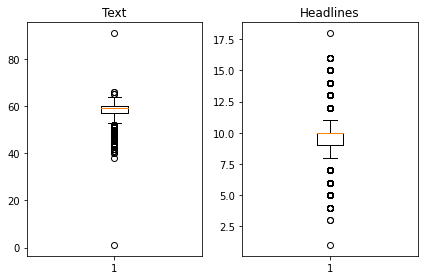

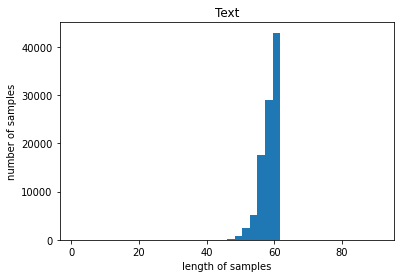

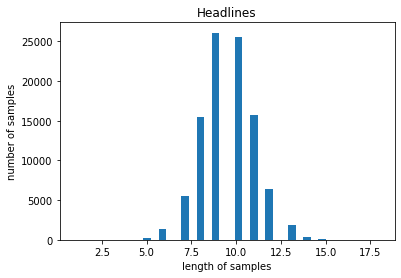

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
text_max_len = 62
headlines_max_len = 13
print('=3')

=3


In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 62 이하인 샘플의 비율: 0.9997153314355429
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9957706384709232


In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97916


## (4) 시작 토큰과 종료 토큰 추가하기

In [24]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,"sostoken Have known Hirani for yrs, what if Me...","Have known Hirani for yrs, what if MeToo claim..."


In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


 훈련 데이터와 테스트 데이터를 분리

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[55778 29421 36992 ... 79085  9880 87190]


정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.

In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19583


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78333
훈련 레이블의 개수 : 78333
테스트 데이터의 개수 : 19583
테스트 레이블의 개수 : 19583


## (5) 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 91273
등장 빈도가 6번 이하인 희귀 단어의 수: 66532
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24741
단어 집합에서 희귀 단어의 비율: 72.89340768902085
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.743295961497961


 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거

In [32]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1, 181, 28, 118, 638, 51, 75, 833, 2, 4497, 5, 1, 279, 214, 3516, 147, 12, 48, 1009, 6724, 15, 1, 1170, 4, 382, 1, 5280, 578, 962, 6, 208, 1304, 27, 379, 1742, 19, 1308, 1735, 28, 34, 111, 7994, 15, 18, 75, 2080, 4, 568, 6, 3805, 1520, 4, 1346, 9, 274], [3, 41, 2366, 1016, 7, 119, 1300, 11, 41, 59, 210, 137, 200, 38, 5281, 2657, 17, 2382, 7, 216, 90, 7, 45, 576, 3226, 5715, 205, 9, 45, 3226, 7, 267, 145, 4463, 684, 7652, 45, 445, 2, 486, 1389, 141, 1, 48, 4039, 5, 1, 2028, 1, 1016, 29, 711, 4650, 16, 1, 1937, 389], [1, 7293, 8, 174, 1, 31, 13, 174, 2, 1, 1969, 2859, 6, 3174, 4, 37, 252, 4563, 70, 9, 1, 48, 76, 1, 853, 12, 174, 4, 3, 724, 4563, 9, 24, 272, 490, 1, 7293, 8, 4, 1, 659, 4627, 2887, 2, 2859, 50, 20, 16]]


In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40725
등장 빈도가 5번 이하인 희귀 단어의 수: 29447
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11278
단어 집합에서 희귀 단어의 비율: 72.30693677102516
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.194631658244509


In [36]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1573, 7, 500, 346, 1977], [1, 39, 7, 159, 13, 469], [1, 743, 789, 4, 570, 5, 45, 59], [1, 404, 83, 3, 22, 4, 707, 30, 1840, 291, 1514], [1, 7, 159, 9]]
target
decoder  [[1573, 7, 500, 346, 1977, 2], [39, 7, 159, 13, 469, 2], [743, 789, 4, 570, 5, 45, 59, 2], [404, 83, 3, 22, 4, 707, 30, 1840, 291, 1514, 2], [7, 159, 9, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 19
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 78314
훈련 레이블의 개수 : 78314
테스트 데이터의 개수 : 19580
테스트 레이블의 개수 : 19580


## (6) 패딩하기

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('패딩 완료!')

패딩 완료!


# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 62, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 62, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 메커니즘

In [43]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 62, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 62, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련하기
- EarlyStopping : 특정 조건이 충족되면 훈련을 멈추는 역할
- 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
- 훈련 완료 후 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화 

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 261s 825ms/step - loss: 3.6971 - val_loss: 3.4511
Epoch 2/50
306/306 [==============================] - 249s 815ms/step - loss: 3.2651 - val_loss: 3.0956
Epoch 3/50
306/306 [==============================] - 249s 815ms/step - loss: 2.9829 - val_loss: 2.8822
Epoch 4/50
306/306 [==============================] - 249s 813ms/step - loss: 2.7975 - val_loss: 2.7432
Epoch 5/50
306/306 [==============================] - 249s 812ms/step - loss: 2.6643 - val_loss: 2.6495
Epoch 6/50
306/306 [==============================] - 247s 809ms/step - loss: 2.5593 - val_loss: 2.5743
Epoch 7/50
306/306 [==============================] - 249s 814ms/step - loss: 2.4712 - val_loss: 2.5061
Epoch 8/50
306/306 [==============================] - 248s 810ms/step - loss: 2.3962 - val_loss: 2.4575
Epoch 9/50
306/306 [==============================] - 248s 810ms/step - loss: 2.3289 - val_loss: 2.4159
Epoch 10/50
306/306 [==============================] - 248s 810m

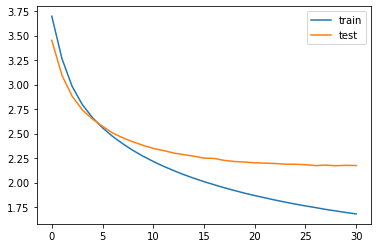

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [52]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [54]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : e commerce major flipkart is in preliminary talks to buy a minority stake in the platform the startup may be valued at 500 700 million if the proposed deal with flipkart goes through according to reports last year raised 85 million from group accel partners saif partners and network 18 at a valuation of over million 
실제 요약 : flipkart in talks to buy stake in 
예측 요약 :  flipkart may buy stake in startup report


원문 : taapsee pannu has said that she has heard stories of sexual harassment in bollywood but she herself has not faced any sexual harassment otherwise she would've probably helped it it is not that it does not happen it does people probably aren't ready to openly talk about it because there are a lot of attached to it she added 
실제 요약 : of sexual harassment in b'wood says taapsee 
예측 요약 :  i wasn't sexual harassment taapsee


원문 : hackers on sunday claimed to have accessed trai chief rs sharma's bank account details and deposited ã¢ââ¹1 in his bank account to highlight the 

# Step 5. Summa을 이용해서 추출적 요약해보기
## (1) 데이터 다운로드

In [75]:
import requests
from summa.summarizer import summarize

In [77]:
data.head()

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,"sostoken Have known Hirani for yrs, what if Me...","Have known Hirani for yrs, what if MeToo claim..."


## (2) summarize 사용하기

In [78]:
print('Summary:')
#print(summarize(text, ratio=0.005))
print(summarize(data['text'][i], ratio=0.005))
#print(summarize(text['text'].apply(str).iloc[1], ratio=0.005))

Summary:



In [74]:
print('Summary:')
print(summarize(a['text'][i], ratio=0.005, split=True))

Summary:
[]


In [ ]:
print('Summary:')
print(summarize(datatext, words=50))

# 🤔회고🤔